# Compare LDA, LSA, etc. ... on bag-of-words approaches

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user
target_month = config.target_month

In [36]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [37]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))

tweets_english['text_processed'] = tweets_english['text_processed'].apply(lambda x: list(map(lambda s: s.lower(),x)))
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
#relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [38]:
X_train_en[-10:-1]

8838    @jphjulstad oracle's palette of digital capabilities for utilities https://t.co/ckg0ic9b30 @soac...
8839    webinar modern datacenters are open with @gabyschilder sign up now https://t.co/zvvf29evt1 opens...
8840    @oraclesk @oraclesk and the mess becomes even bigger usb-c is not equal usb-c wtf was apple thin...
8841    @lukaseder @rotnroll666 don't be afraid embrace the new possibilities :) besides i've been worki...
8842    @franckpachot if 12.2 index usage tracking counts dbms_stats not fk lock avoidance then not suff...
8843    @klingspoon do you like @vertx_project do you like @javaooq https://t.co/nchs81g0c7 connects the...
8844    @sfonplsql writing java with @oracledatabase then @javaooq offers some great functionality to he...
8845    @martindba @mikedietrichde @sjaffarhussain @jeanremacle yes i am at tech 16 however jean was pre...
8846    @klingspoon do you like @vertx_project do you like @javaooq https://t.co/nchs81g0c7 connects the...
Name: text_wo_#, dtype: obje

# Using CountVectorizer

In [39]:
min_freq = 5
count_vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, min_df=min_freq,
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = count_vectorizer.fit_transform(X_train_en)
feature_names = count_vectorizer.get_feature_names()
len(feature_names)
words_matrix.shape
feature_names[:50]

['):',
 ');',
 '-0.10',
 '.',
 '0',
 '0.1',
 '1',
 '1.2',
 '1.3',
 '1/2',
 '1/3',
 '10',
 '100',
 '101',
 '10:30',
 '10am',
 '11',
 '11/15',
 '11/16',
 '11g',
 '12',
 '12.1',
 '12.2',
 '12/8',
 '121',
 '12c',
 '12cr',
 '12cr2',
 '13c',
 '14',
 '15',
 '16',
 '164',
 '168',
 '17',
 '170',
 '17th',
 '1893',
 '19-20',
 '1976',
 '1989',
 '19:00',
 '1st',
 '2',
 '2.0',
 '2.1',
 '2/2',
 '2/3',
 '20',
 '2014']

## LSA with CountVectorizer

[ 0.12324422  0.13442841  0.05886564  0.07594309]
(4, 3422)


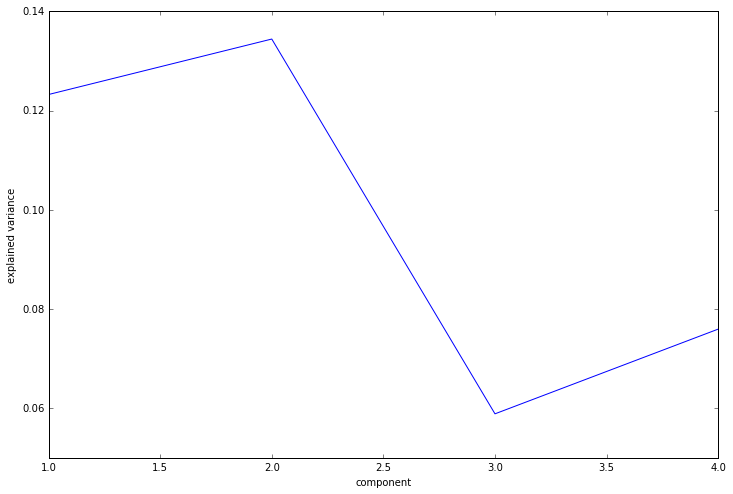

In [40]:
svd = TruncatedSVD(n_components=4, n_iter=10)
#svd = TruncatedSVD(n_components=10, algorithm = 'arpack')
X = svd.fit_transform(words_matrix)
print(svd.explained_variance_)

print(svd.components_.shape)

plt.figure(figsize = (12, 8))
plt.xlabel('component')
plt.ylabel('explained variance')
plt.plot(np.arange(1,svd.n_components+1), svd.explained_variance_)
plt.show()


In [41]:
n_top_words = 10
for comp_idx, component in enumerate(svd.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.7: oracle
0.3: database
0.3: cloud
0.3: 12.2
0.1: new
0.1: available
0.1: @mikedietrichde
0.1: sql
0.1: @sfonplsql
0.1: 0.1
Component #1:
0.4: trump
0.3: tower
0.3: @exagriddba
0.3: street
0.3: entrance
0.3: 56th
0.3: residential
0.3: https://t.co/xr1hfvxmqv
0.3: locked
0.0: donald
Component #2:
0.3: @sfonplsql
0.3: @lukaseder
0.2: sql
0.2: new
0.2: data
0.2: bigdata
0.2: @msftcitynext
0.2: learn
0.2: @talend
0.1: make
Component #3:
0.3: @msftcitynext
0.3: scewc16
0.3: msftcitynext
0.2: learn
0.2: partners
0.2: stop
0.2: make
0.2: database
0.1: cities
0.1: @lukaseder


# LSI from gensim

In [42]:
min_freq = 5
from gensim.models import lsimodel
from gensim import corpora
tweets_english['stopwords_removed'] = tweets_english['text_wo_#'].apply(
    lambda x: [word for word in x if word not in stopwords_filtered])
d = corpora.Dictionary(tweets_english['stopwords_removed'])
d.filter_extremes(no_below=min_freq, no_above=0.5, keep_n=None)
print(d.get(10))

corpus = [d.doc2bow(text) for text in tweets_english['text_wo_#'] if text not in stopwords_filtered]
print(corpus[100:105])

lsi = lsimodel.LsiModel(corpus, num_topics=4, id2word=d)

reasons
[[(177, 1), (1978, 1), (2351, 1), (2421, 1), (2903, 1), (2950, 1), (3350, 1)], [(564, 1), (1423, 1), (1456, 1), (2198, 1), (2344, 1), (2752, 1), (2801, 1)], [(1723, 1), (2477, 1), (2521, 1), (2854, 1)], [(52, 1), (229, 1), (403, 1), (2225, 1), (2283, 1), (2476, 1)], [(669, 1), (670, 1), (705, 1), (946, 1), (1156, 1), (1391, 1), (1492, 1), (1736, 1), (1920, 1), (2283, 1), (2833, 1)]]


In [43]:
lsi.show_topics(-1, formatted=True)

[(0,
  '0.714*"oracle" + 0.337*"database" + 0.287*"cloud" + 0.274*"12.2" + 0.148*"new" + 0.136*"available" + 0.126*"@mikedietrichde" + 0.095*"sql" + 0.080*"@sfonplsql" + 0.076*"0.1"'),
 (1,
  '0.372*"trump" + 0.337*"tower" + 0.330*"@exagriddba" + 0.327*"street" + 0.326*"entrance" + 0.326*"residential" + 0.326*"56th" + 0.326*"locked" + 0.326*"https://t.co/xr1hfvxmqv" + 0.011*"donald"'),
 (2,
  '-0.317*"oracle" + 0.276*"@sfonplsql" + 0.265*"@lukaseder" + 0.247*"sql" + 0.186*"new" + 0.182*"data" + 0.178*"bigdata" + 0.169*"@msftcitynext" + 0.168*"learn" + 0.161*"@talend"'),
 (3,
  '-0.321*"@msftcitynext" + 0.298*"@sfonplsql" + -0.279*"scewc16" + -0.257*"msftcitynext" + 0.256*"sql" + -0.232*"learn" + 0.231*"new" + -0.224*"partners" + -0.210*"stop" + -0.208*"make"')]

In [44]:
# U
lsi.projection.u

array([[  2.61407810e-03,   1.26966531e-04,   7.37722640e-03,
          1.87433897e-03],
       [  2.72794651e-04,   1.69961358e-05,   1.10358264e-03,
          3.69982514e-04],
       [  5.32028911e-04,   2.49852234e-06,   1.31651878e-03,
          2.96450568e-04],
       ..., 
       [  2.11146819e-04,   1.24347395e-04,   1.34418621e-03,
         -1.33083832e-03],
       [  1.73813669e-03,  -3.33821450e-06,   4.92448638e-03,
          5.48056126e-03],
       [  6.58271654e-04,   1.20186062e-05,   2.11732375e-03,
          4.21794610e-04]])

In [45]:
# singular values
lsi.projection.s

array([ 37.23639873,  34.82344777,  27.59702849,  25.91870519])

## PCA with CountVectorizer

In [46]:
# compare with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(words_matrix.toarray())
print(pca.explained_variance_ratio_) 

[ 0.01733932  0.01604889]


In [47]:
for comp_idx, component in enumerate(pca.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.6: oracle
0.3: database
0.2: 12.2
0.2: cloud
0.1: available
0.1: @mikedietrichde
0.1: new
0.1: 0.1
0.1: 12cr2
0.0: 2
Component #1:
0.5: oracle
0.3: trump
0.2: tower
0.2: database
0.2: @exagriddba
0.2: street
0.2: entrance
0.2: residential
0.2: 56th
0.2: https://t.co/xr1hfvxmqv


## Gaussian mixture with CountVectorizer

In [48]:
from sklearn import mixture
em = mixture.GaussianMixture(n_components=2, covariance_type='full')
#em = mixture.BayesianGaussianMixture(n_components=5)
em.fit(words_matrix.toarray())

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [67]:
print('Iterations: {}, converged: {}'.format(em.n_iter_, em.converged_))
print('Component weights: {}'.format(em.weights_))
print('Component means: {}'.format(em.means_))
print('Predicted component: {}'.format(em.predict(words_matrix[:5].toarray())))
print('Probability per component: {}'.format(em.predict_proba(words_matrix[:5].toarray())))
print('weighted log prob of samples: {}'.format(em.score_samples(words_matrix[:5].toarray())))

Iterations: 2, converged: True
Component weights: [ 0.95716546  0.04283454]
Component means: [[ 0.00188924  0.00082654  0.00059039 ...,  0.00094462  0.00082654
   0.00094462]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


ValueError: Expected the input data X have 3422 features, but got 17646 features

# Hierarchical Dirichlet Process

In [73]:
from gensim.models import HdpModel
hdpm = HdpModel(corpus=corpus, id2word=d)

In [74]:
hdpm.show_topics()

['topic 0: 0.002*windows + 0.002*tips + 0.002*blockchain + 0.002*happened + 0.002*know + 0.002*visible + 0.002*good + 0.002*computer + 0.002*pieces + 0.002*quickly + 0.002*pluggable + 0.002*https://t.co/bvdzo2qif9 + 0.002*iot + 0.002*forecast + 0.002*@meetmila + 0.002*stefan + 0.002*@csierra_usa + 0.002*cheerful + 0.001*https://t.co/lsvshjh4by + 0.001*original',
 'topic 1: 0.003*guide + 0.002*trace + 0.002*dwautomation + 0.002*dev + 0.002*@drune + 0.002*upgrades + 0.002*implemented + 0.002*@oraclemagazine + 0.002*@tobiasdemldba + 0.002*pipelines + 0.002*fantastic + 0.002*wetterfideris + 0.002*v2 + 0.002*resource + 0.002*production + 0.002*ok + 0.002*resell + 0.002*marketing + 0.002*biz + 0.001*oraclecloudday',
 'topic 2: 0.002*@djeze416 + 0.002*guys + 0.002*giving + 0.002*challenge + 0.002*https://t.co/ccu2sai4td + 0.002*christmas + 0.002*standing + 0.002*aop + 0.002*ｒｅｔｗｅｅｔ + 0.002*prefer + 0.002*better + 0.002*vcf + 0.002*trail + 0.002*tim + 0.001*window + 0.001*doag + 0.001*2x + 0.0

# Using tf-idf vectorizer

## LSA with tf-idf vectorizer

In [50]:
tfidf_vectorizer = TfidfVectorizer(analyzer = "word", tokenizer = str.split, max_df=0.5, min_df=5,
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = tfidf_vectorizer.fit_transform(X_train_en)
feature_names = tfidf_vectorizer.get_feature_names()
len(feature_names), tfidf_vectorizer.idf_.shape

(3422, (3422,))

[ 0.01501676  0.00504029  0.00631352  0.00428398]
(4, 3422)


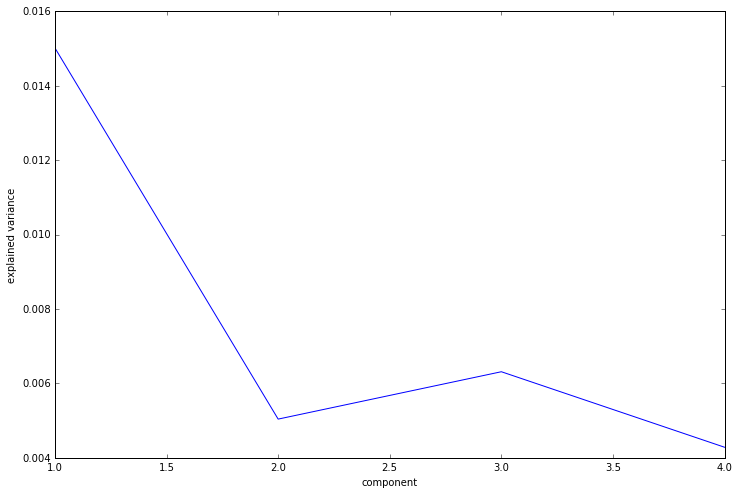

In [51]:
svd = TruncatedSVD(n_components=4, n_iter=10)
#svd = TruncatedSVD(n_components=10, algorithm = 'arpack')
X = svd.fit_transform(words_matrix)
print(svd.explained_variance_)

print(svd.components_.shape)

plt.figure(figsize = (12, 8))
plt.xlabel('component')
plt.ylabel('explained variance')
plt.plot(np.arange(1,svd.n_components+1), svd.explained_variance_)
plt.show()


In [52]:
for comp_idx, component in enumerate(svd.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.3: trump
0.3: tower
0.3: street
0.3: @exagriddba
0.3: residential
0.3: https://t.co/xr1hfvxmqv
0.3: 56th
0.3: locked
0.3: entrance
0.0: donald
Component #1:
0.5: oracle
0.3: database
0.3: 12.2
0.2: cloud
0.2: available
0.2: new
0.2: @mikedietrichde
0.1: sql
0.1: @lukaseder
0.1: @sfonplsql
Component #2:
0.4: @msftcitynext
0.4: scewc16
0.3: msftcitynext
0.3: partners
0.3: make
0.2: learn
0.2: cities
0.2: smartsolutions
0.2: sustainable
0.2: discussing
Component #3:
0.3: oracle
0.2: database
0.1: available
0.1: msftcitynext
0.1: scewc16
0.1: @msftcitynext
0.1: @mikedietrichde
0.1: partners
0.1: 12cr2
0.1: smartsolutions


## PCA with tf-idf vectorizer

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(words_matrix.toarray())
print(pca.explained_variance_ratio_) 

[ 0.01531501  0.0071762 ]


In [54]:
for comp_idx, component in enumerate(pca.components_):
        print("Component #%d:" % comp_idx)
        top_n = ['{}: {}'.format(round(component[i],1), feature_names[i]) for i in component.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))


Component #0:
0.3: trump
0.3: tower
0.3: street
0.3: @exagriddba
0.3: residential
0.3: locked
0.3: https://t.co/xr1hfvxmqv
0.3: 56th
0.3: entrance
0.0: donald
Component #1:
0.6: oracle
0.4: database
0.3: 12.2
0.2: cloud
0.2: available
0.2: @mikedietrichde
0.1: 12cr2
0.1: 0.1
0.1: new
0.1: documentation


## Gaussian mixture with tf-idf vectorizer

In [22]:
from sklearn import mixture
em = mixture.GaussianMixture(n_components=2, covariance_type='full')
#em = mixture.BayesianGaussianMixture(n_components=5)
em.fit(words_matrix.toarray())

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [23]:
print('Iterations: {}, converged: {}'.format(em.n_iter_, em.converged_))
print('Component weights: {}'.format(em.weights_))
print('Component means: {}'.format(em.means_))
print('Predicted component: {}'.format(em.predict(words_matrix[:5].toarray())))
print('Probability per component: {}'.format(em.predict_proba(words_matrix[:5].toarray())))
print('weighted log prob of samples: {}'.format(em.score_samples(words_matrix[:5].toarray())))

Iterations: 4, converged: True
Component weights: [ 0.875  0.125]
Component means: [[ 0.00265752  0.004442    0.00107053 ...,  0.00150814  0.00234303
   0.00084749]
 [ 0.          0.00102117  0.         ...,  0.          0.00397957  0.        ]]
Predicted component: [0 0 1 0 1]
Probability per component: [[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]
weighted log prob of samples: [ 4433.67653346  4433.67653346  7080.36452478  3792.7477112   7006.89822864]


# LDA

## LDA with CountVectorizer

In [55]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
/home/key/python/anaconda2/envs/p35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value

In [56]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
140.8: oracle
114.4: @lukaseder
105.1: cloud
92.0: new
88.7: trump
83.3: thanks
82.3: 12.2
79.3: like
76.7: great
75.7: data
75.4: @sfonplsql
72.2: database
72.1: way
72.0: :)
71.1: get
68.4: it's
66.2: sql
64.5: see
63.0: bigdata
62.9: tower



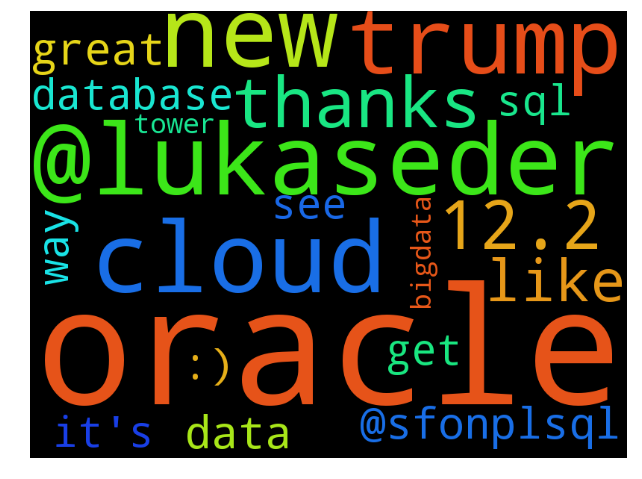

In [66]:
model = lda_models[0]
n_top_words = 20
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
133.7: oracle
88.8: new
88.1: trump
81.8: 12.2
70.6: way
63.9: sql
62.4: tower
61.0: @exagriddba
60.4: @sfonplsql
57.3: database
55.5: street
54.2: entrance
54.2: retweet
54.1: locked
54.1: 56th
54.1: https://t.co/xr1hfvxmqv
54.1: residential
52.3: @franckpachot
48.6: tool
47.2: lazy

Topic #1:
111.6: @lukaseder
60.5: free
60.5: data
59.0: cloud
57.5: @oracleace
57.1: @talend
56.0: thanks
51.9: iot
51.7: bigdata
51.2: @msftcitynext
50.4: don't
50.4: get
50.2: good
49.8: devoxx
49.3: learn
48.8: :)
44.9: day
44.0: great
43.8: see
43.0: next



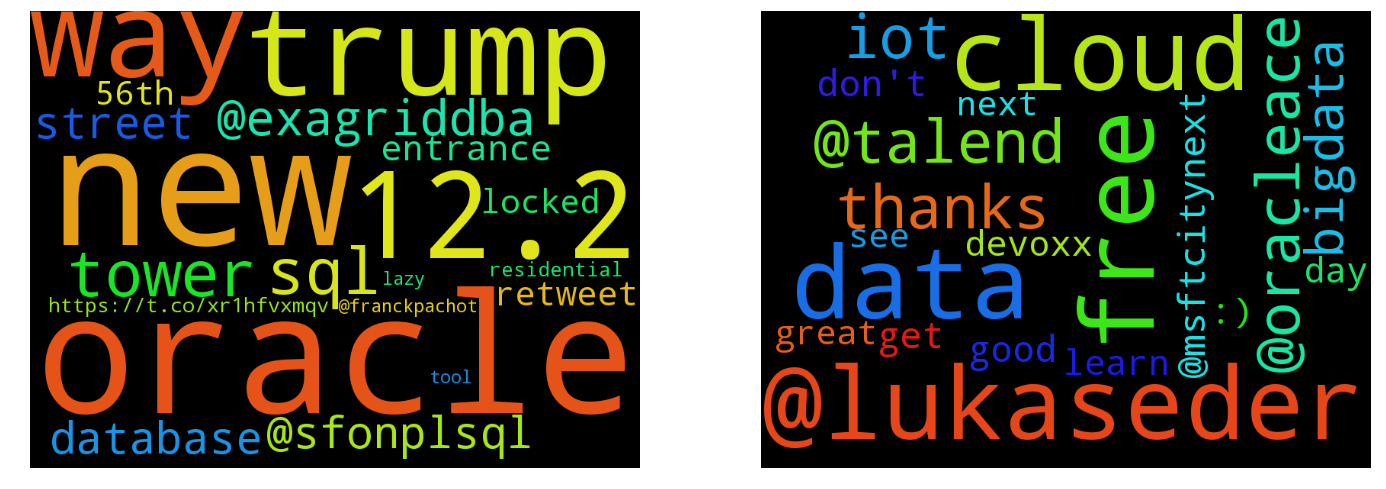

In [58]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
129.8: oracle
81.6: 12.2
71.5: database
50.6: i'm
47.2: new
46.6: way
45.9: @franckpachot
45.7: lazy
43.7: cloud
42.1: 2
41.0: available
38.9: @mikedietrichde
38.4: still
37.4: @nephentur
36.8: use
35.8: would
35.0: features
34.4: sql
34.0: :)
33.0: it's

Topic #1:
87.9: trump
64.2: like
62.2: tower
60.9: free
60.8: @exagriddba
59.8: @lukaseder
55.3: street
54.1: entrance
53.9: residential
53.9: https://t.co/xr1hfvxmqv
53.9: 56th
53.9: locked
51.1: iot
51.0: @msftcitynext
50.0: good
48.6: thanks
47.6: make
45.6: devoxx
39.7: don't
39.3: :-)

Topic #2:
74.4: data
62.2: bigdata
57.0: @talend
56.5: retweet
51.2: tool
48.6: 2016
43.7: check
41.4: iamcp
39.7: cloud
39.3: new
37.0: using
35.5: @sfonplsql
34.4: it's
34.4: business
34.3: thanks
34.1: video
33.4: growth
32.0: top
31.3: sql
30.7: blog



(0.0, 1.0, 0.0, 1.0)

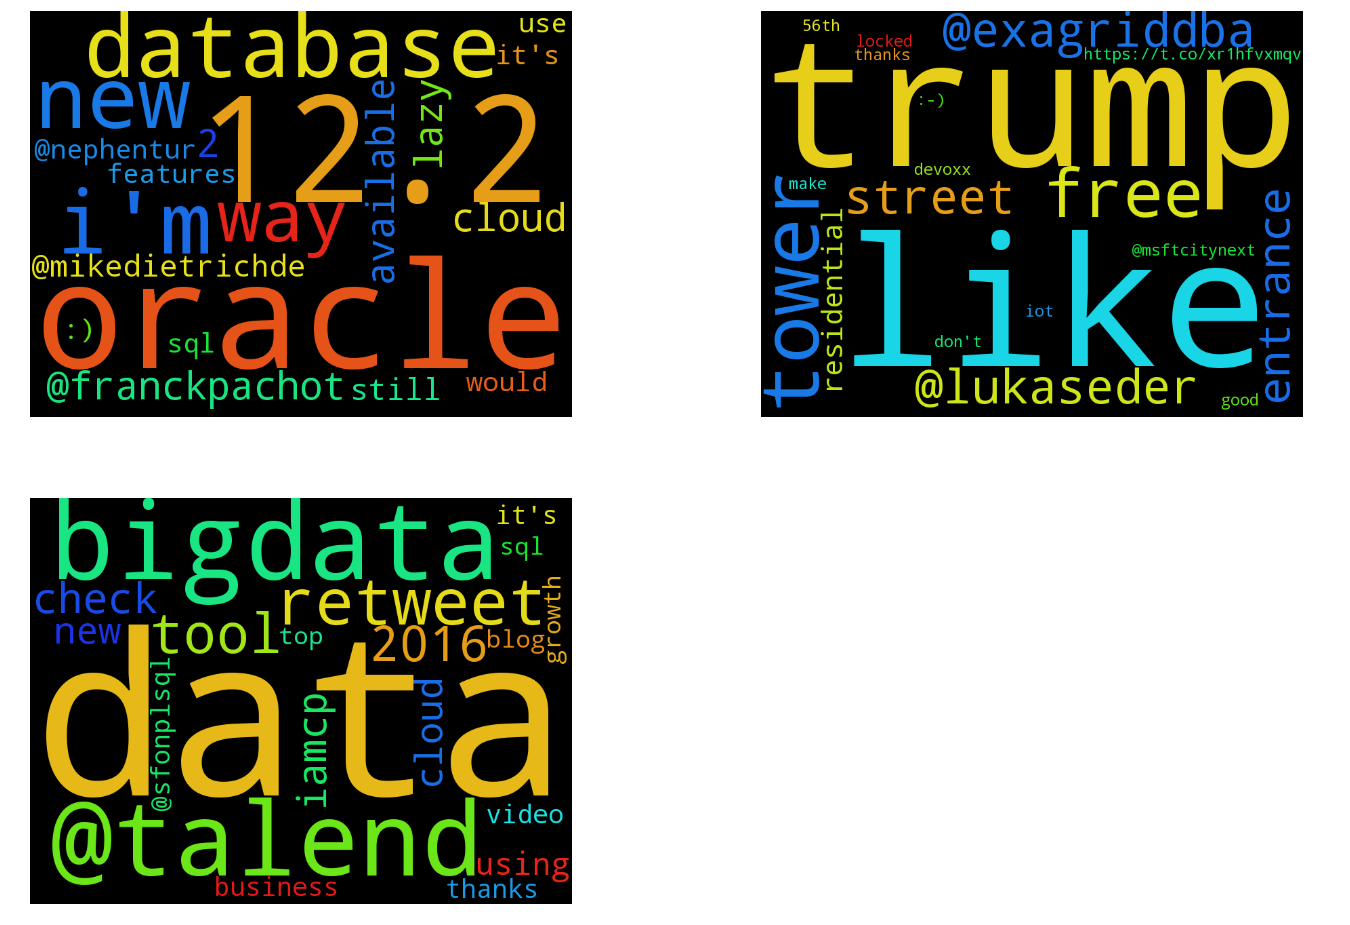

In [59]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
116.7: oracle
81.5: 12.2
69.7: database
54.0: new
42.7: cloud
42.2: @oracledatabase
38.8: @franckpachot
37.3: features
36.5: available
32.5: like
31.2: @lukaseder
30.7: thank
29.9: world
28.9: 2
28.0: start
25.4: @mikedietrichde
24.9: would
24.6: @javaooq
24.2: @sfonplsql
23.4: online

Topic #1:
52.0: learn
51.8: iot
50.8: @msftcitynext
50.1: know
43.8: make
35.8: partners
35.0: scewc16
33.1: msftcitynext
32.9: cloud
32.6: security
31.9: people
29.5: data
29.4: @lukaseder
28.1: need
25.3: marketing
25.2: aws
25.1: webinar
24.9: service
24.6: customer
23.5: oracle

Topic #2:
87.9: trump
62.1: tower
60.7: @exagriddba
57.3: retweet
55.2: street
54.0: entrance
53.8: https://t.co/xr1hfvxmqv
53.8: residential
53.8: 56th
53.8: locked
52.9: @lukaseder
41.3: iamcp
38.5: devoxx
35.9: follow
35.6: right
34.9: one
33.3: got
31.1: @oracle
29.9: like
28.3: @soacommunity

Topic #3:
62.0: way
61.7: bigdata
61.0: free
57.8: @oracleace
56.7: @talend
56.5: thanks
47.4: good
47.1: lazy
45.8: it'

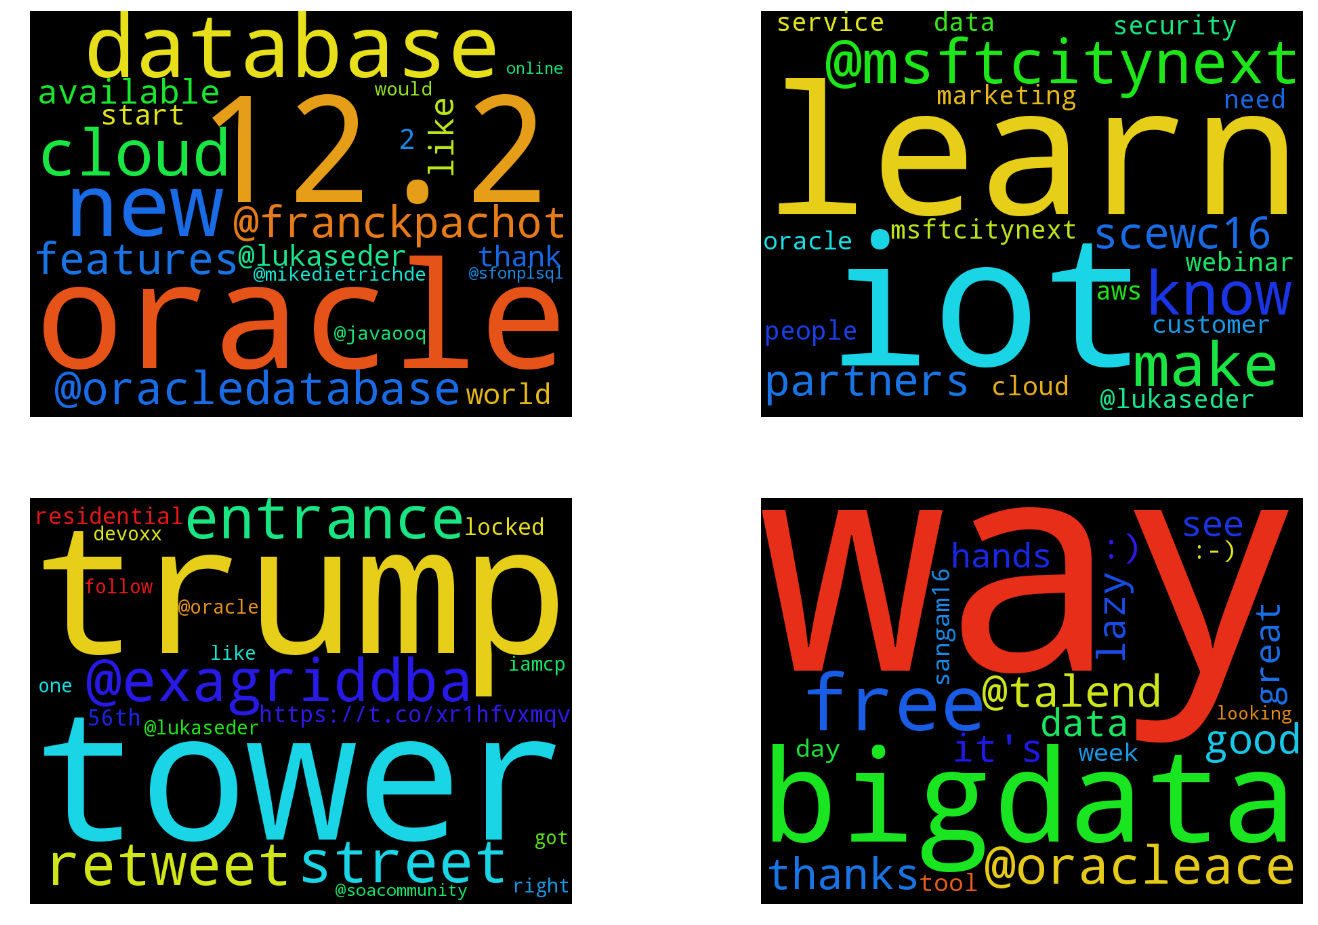

In [60]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [62]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)
co_occurrences.shape

(17646, 17646)

In [63]:
vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.head()

,0,1,2,3,4,5,6,7,8,9,...,17636,17637,17638,17639,17640,17641,17642,17643,17644,17645
word,,,,,,,,,,,,,,,,,,,,,
(:,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(=,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
);,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
co_occurrences.columns = vocab
co_occurrences.head()

,(:,(=,):,);,-,-0.10,-0.20,.,..,...,...,🙄,🙈,🙌,🙏,🚀,🚨,🚽,🤔,🤖,🤘
word,,,,,,,,,,,,,,,,,,,,,
(:,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(=,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
);,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Co-occurrences for: oracle
database           279
12.2               201
cloud              199
available          123
@mikedietrichde    116
12cr2               77
0.1                 68
2                   60
12c                 59
new                 58
documentation       52
see                 51
Name: oracle, dtype: int64




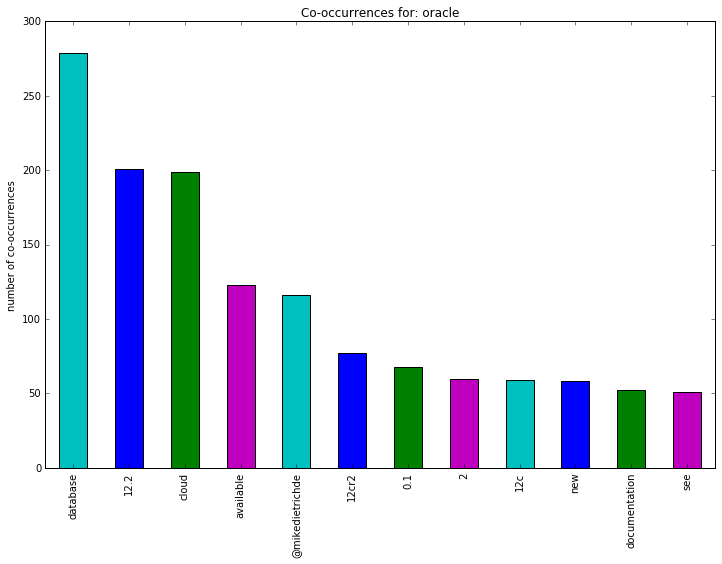

Co-occurrences for: microsoft
iamcp        29
teams        18
cloud        15
iot          15
office       12
azure        11
available    10
meeting      10
join          9
day           9
@             9
swiss         9
Name: microsoft, dtype: int64




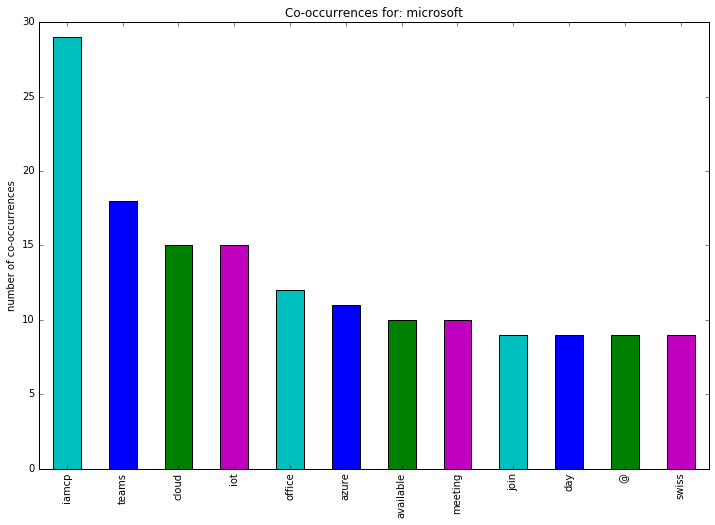

Co-occurrences for: talend
@talend    44
5          20
cloud      19
bigdata    18
advice     17
top        17
pieces     17
data       17
views      17
key        17
future     17
cto        17
Name: talend, dtype: int64




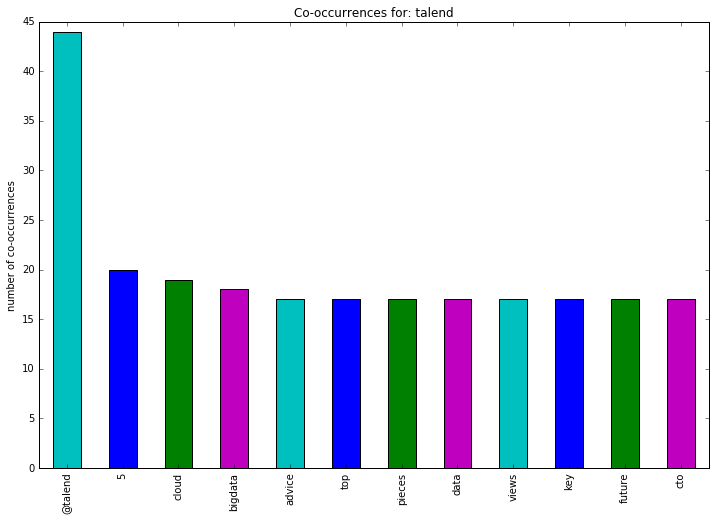

Co-occurrences for: bigdata
@talend        147
data            68
iot             47
hadoop          40
aws             38
building        34
datascience     31
free            29
5               28
real-world      25
blog            23
success         23
Name: bigdata, dtype: int64




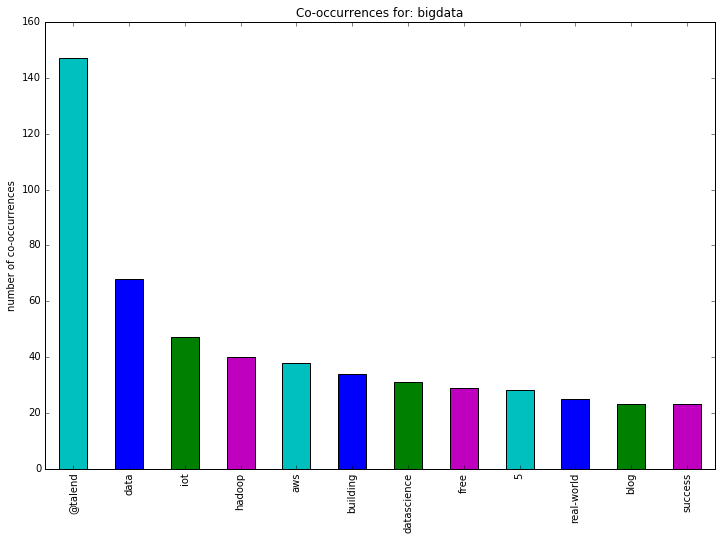

Co-occurrences for: cloud
oracle             199
database            71
@oracle             68
12.2                64
available           46
security            36
@mikedietrichde     34
service             34
data                32
key                 29
get                 29
see                 28
Name: cloud, dtype: int64




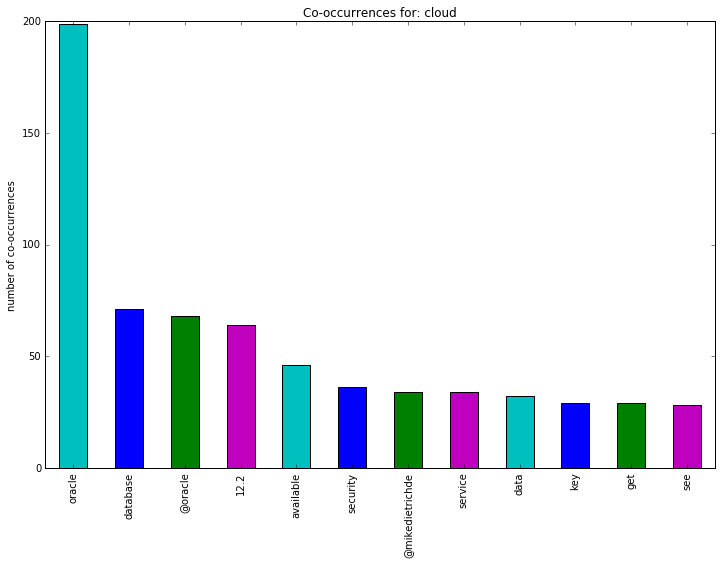

Co-occurrences for: machinelearning
datascience                9
@talend                    8
trees                      5
talend                     5
https://t.co/dhnv6e6i06    5
decision                   5
apachespark                5
nlproc                     5
intro                      5
101                        5
https://t.co/…             4
@harvardbiz                4
Name: machinelearning, dtype: int64




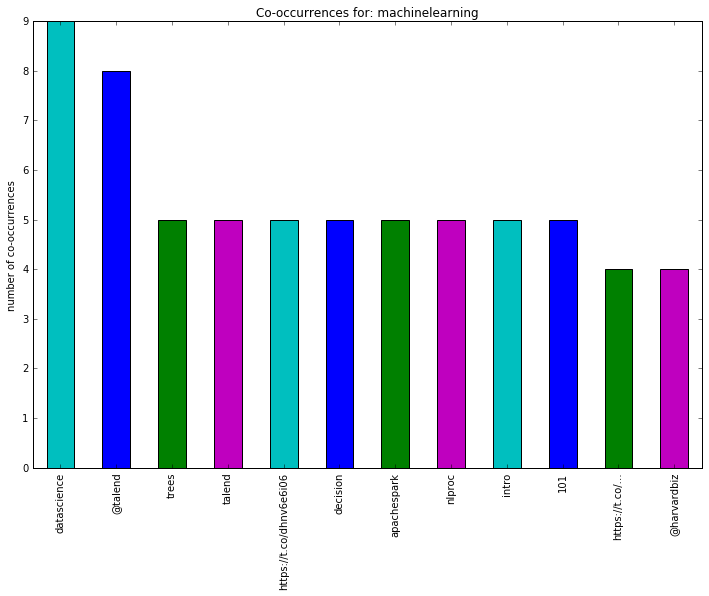

Co-occurrences for: datascience
bigdata            31
@talend            15
@mtuchen           11
year's             10
election           10
making             10
impact             10
data                9
machinelearning     9
master              8
award               8
2016                8
Name: datascience, dtype: int64




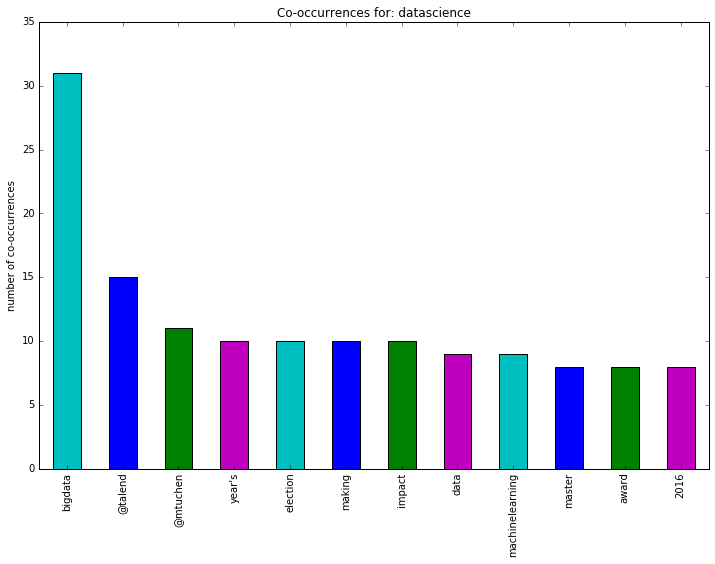

Co-occurrences for: deeplearning
machinelearning           3
machines                  3
helpful                   2
super                     2
boltzmann                 2
artificialintelligence    2
lecture                   2
find                      2
@zkajdan                  2
driving                   2
automated                 2
works                     2
Name: deeplearning, dtype: int64




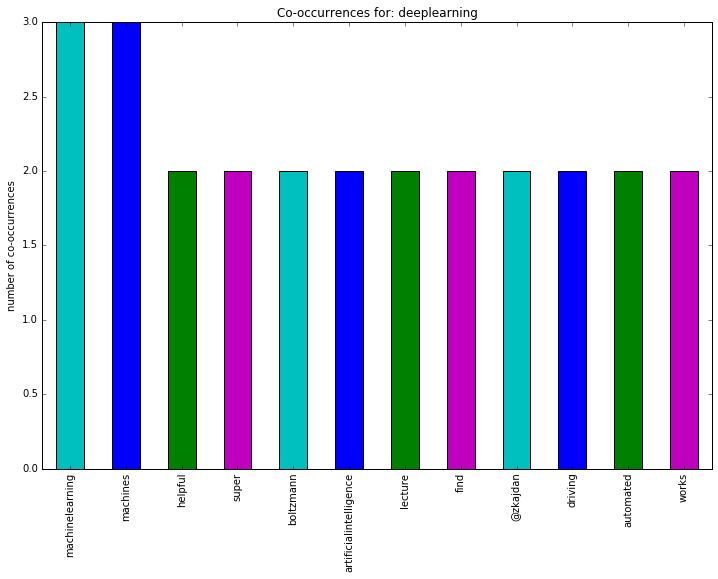

In [65]:
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    sorted = coocs.sort_values(ascending = False)
    return sorted[:n]

def plot_co_occurrences(word, coocs):
    plt.figure(figsize = (12, 8))
    plt.ylabel('number of co-occurrences')
    plt.title('Co-occurrences for: {}'.format(word))
    coocs.plot(kind='bar', color = colors)
    plt.show()
    
words = ['oracle', 'microsoft', 'talend', 'bigdata', 'cloud', 'machinelearning', 'datascience', 'deeplearning']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)
